In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from sklearn.tree import DecisionTreeClassifier 
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelBinarizer
from sklearn.model_selection import train_test_split, PredefinedSplit

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.pipeline import Pipeline

rs=42

import warnings
warnings.filterwarnings('ignore')

In [2]:
def cap_outliers(df, tail=10):   
    # tail is used to decide the upper and lower bound inside which the outliers are pushed
    lb = tail   # lower bound
    ub = 100 - tail   # upper bound
    for col in df.columns:
        if col != 'id' and col != 'label': 
            data = df[col]
            tenth_percentile = np.percentile(data, lb)
            ninetieth_percentile = np.percentile(data, ub)   
            new = np.where(data < tenth_percentile, tenth_percentile, data)
            new = np.where(new > ninetieth_percentile, ninetieth_percentile, new)
            df[col] = new
    return df   
    

def plot_data(df_train, title):
    fig = plt.figure(figsize=(20, 15))
    plt.title(title)
    outer = gridspec.GridSpec(7, 6, wspace=0.5, hspace=0.6)
    i = 0

    for col in df_train.columns:
        if col != 'id' and col != 'label':   
            data = df_train[col]
            inner = gridspec.GridSpecFromSubplotSpec(2, 1,  subplot_spec=outer[i], wspace=0.1, hspace=0.1, 
                                                     height_ratios=(.85, .15))
            ax_box = plt.Subplot(fig, inner[1])
            ax_hist = plt.Subplot(fig, inner[0])
            sns.boxplot(data, ax=ax_box)
            sns.distplot(data, ax=ax_hist)
            ax_box.set(yticks=[])
            ax_hist.set(xticks=[], xlabel=None)
            sns.despine(ax=ax_hist)
            sns.despine(ax=ax_box, left=True)

            fig.add_subplot(ax_box)        
            fig.add_subplot(ax_hist)
            i+= 1    

In [3]:
df_train = pd.read_csv('train.csv')
df_train.shape

(3796, 43)

In [4]:
capping_cut_off = 15  
# df_train = cap_outliers(df_train, capping_cut_off)
print(df_train.shape)

(3796, 43)


In [5]:
X, y = df_train.drop(axis=1, columns=['id', 'label']), df_train.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42
                                                   )
X_train.shape

(3036, 41)

# Custom OVR
### 0 vs rest

In [6]:
y0_train = y_train
y0_train[y0_train != 0] = -1
y0_train.value_counts()

-1    2030
 0    1006
Name: label, dtype: int64

In [7]:
svc = SVC(C=1, break_ties=False, degree=2, gamma='scale', kernel='poly', shrinking=True)

pipe = Pipeline([   
    ('sampling', SMOTE(sampling_strategy={-1:2100,  0:1600}, random_state=rs)),
#     ('sampling', CondensedNearestNeighbour(random_state=42)),
    ('classifier', RandomForestClassifier(svc)),    
])

alphas_clf = DecisionTreeClassifier()
alphas = alphas_clf.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']
print(len(alphas))

# Hyper-parameters used for tunning
params = {          
    'classifier__n_estimators': [100], # default=100
    'classifier__min_samples_split': [4, ],  # int or float, default=2
    'classifier__min_samples_leaf': [1, ],  # int or float, default=1
    'classifier__min_weight_fraction_leaf': [0, ], # float, default=0.0
    'classifier__max_leaf_nodes': [None], # int, default=None
    'classifier__max_samples': [0.1, 0.2, 0.3], # int or float, default=None
    'classifier__ccp_alpha': alphas,
    
    'classifier__criterion': ['gini', 'entropy', 'log_loss'], 
     'classifier__max_features': ['sqrt', 'log2', None], 
    'classifier__bootstrap': [True,], 
    'classifier__oob_score': [True,], 
    'classifier__warm_start': [True, False], 
    'classifier__class_weight': ['balanced', 'balanced_subsample', None],        
    'classifier__criterion': ['entropy',], 
    'classifier__n_jobs': [-1],
}


# Overriding above parameters with selected Hyper-parameters after tunning
# Overriding to reduce runtime during submission
params = {      
    'classifier__n_estimators':  [100], 
    'classifier__min_samples_split': [2,],   # np.linspace(0.0, 1, 21), 
    'classifier__min_samples_leaf': [0.00015] ,  
    'classifier__min_weight_fraction_leaf': [0.0,], 
    'classifier__max_leaf_nodes': [None],
    'classifier__max_samples': [0.95] , 
#     'classifier__ccp_alpha': [0.0009881422924901185],
    
#     'classifier__criterion': ['gini', 'entropy', 'log_loss'], 
#     'classifier__max_features': ['sqrt', 'log2', None], 
    'classifier__bootstrap': [True,], 
    'classifier__oob_score': [True,], 
    'classifier__warm_start': [True, ], 
    'classifier__class_weight': ['balanced_subsample', ],        
    'classifier__criterion': ['entropy',], 
    'classifier__n_jobs': [-1],
}

186


In [8]:
%%time
clf = GridSearchCV(pipe, params, cv=5, scoring='f1_micro', return_train_score=True, verbose=10, refit=True)
search = clf.fit(X_train, y0_train)
search.best_params_, search.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START classifier__bootstrap=True, classifier__class_weight=balanced_subsample, classifier__criterion=entropy, classifier__max_leaf_nodes=None, classifier__max_samples=0.95, classifier__min_samples_leaf=0.00015, classifier__min_samples_split=2, classifier__min_weight_fraction_leaf=0.0, classifier__n_estimators=100, classifier__n_jobs=-1, classifier__oob_score=True, classifier__warm_start=True
[CV 1/5; 1/1] END classifier__bootstrap=True, classifier__class_weight=balanced_subsample, classifier__criterion=entropy, classifier__max_leaf_nodes=None, classifier__max_samples=0.95, classifier__min_samples_leaf=0.00015, classifier__min_samples_split=2, classifier__min_weight_fraction_leaf=0.0, classifier__n_estimators=100, classifier__n_jobs=-1, classifier__oob_score=True, classifier__warm_start=True;, score=(train=1.000, test=0.850) total time=   5.7s
[CV 2/5; 1/1] START classifier__bootstrap=True, classifier__class_weight

({'classifier__bootstrap': True,
  'classifier__class_weight': 'balanced_subsample',
  'classifier__criterion': 'entropy',
  'classifier__max_leaf_nodes': None,
  'classifier__max_samples': 0.95,
  'classifier__min_samples_leaf': 0.00015,
  'classifier__min_samples_split': 2,
  'classifier__min_weight_fraction_leaf': 0.0,
  'classifier__n_estimators': 100,
  'classifier__n_jobs': -1,
  'classifier__oob_score': True,
  'classifier__warm_start': True},
 0.8478252622908176)

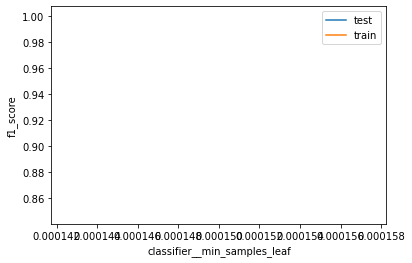

,classifier__min_samples_leaf,f1_score
0,0.00015,0.847825


In [9]:
tunning_parameter = 'classifier__min_samples_leaf'

test_scores = search.cv_results_['mean_test_score']
train_scores = search.cv_results_['mean_train_score'] 

support = search.cv_results_['param_'+tunning_parameter].compressed().astype(np.float)
# support = np.log10(np.array(support))

plt.rcParams["figure.figsize"] = (20,5)
plt.plot(support, test_scores, label='test')
plt.plot(support, train_scores, label='train')
plt.xlabel(tunning_parameter)
plt.ylabel('f1_score')
plt.legend(loc='best')
plt.show()

result_df = pd.DataFrame(list(zip(support, test_scores)),columns=[tunning_parameter, 'f1_score'])
result_df

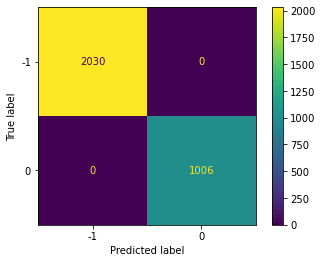

In [10]:
y_train_pred = clf.predict(X_train)
ConfusionMatrixDisplay.from_predictions(y0_train, y_train_pred)

In [11]:
print(classification_report(y0_train, y_train_pred))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      2030
           0       1.00      1.00      1.00      1006

    accuracy                           1.00      3036
   macro avg       1.00      1.00      1.00      3036
weighted avg       1.00      1.00      1.00      3036



In [12]:
f1_score(y0_train, y_train_pred, average='micro')

1.0

In [14]:
y0_test = y_test
y0_test[y0_test != 0] = -1
y0_test.value_counts()

-1    523
 0    237
Name: label, dtype: int64

In [15]:
y_test_pred = clf.predict(X_test)
f1_score(y0_test, y_test_pred, average='micro')

0.85

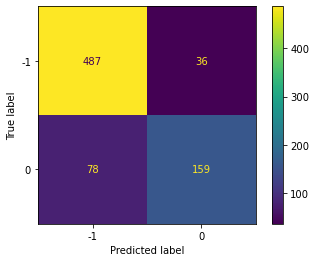

In [16]:
ConfusionMatrixDisplay.from_predictions(y0_test, y_test_pred)

In [17]:
print(classification_report(y0_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.86      0.93      0.90       523
           0       0.82      0.67      0.74       237

    accuracy                           0.85       760
   macro avg       0.84      0.80      0.82       760
weighted avg       0.85      0.85      0.85       760

